# (2 of 3) PCA
---
# AMEX Default
# Dimensionality Reduction: PCA, LDA
### (For future use by Classification Algorithms)
---

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 19:58:26) \n[GCC 7.3.0]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_parquet('./dataset/train_data.parquet')

In [4]:
df['S_2'] = pd.to_datetime(df['S_2'], format='%Y/%m/%d')

In [5]:
category_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']

for col in category_cols:
    df[col] = df[col].astype('category')

In [6]:
my_dictionary = {'CO':0,'CR':1,'CL':2,'XL':3,'XZ':4,'XM':5}
df['D_63'] = df['D_63'].map(my_dictionary)

In [7]:
my_dictionary = {'O':0,'R':1,'U':2,'-1':3}
df['D_64'] = df['D_64'].map(my_dictionary)

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_val = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [9]:
df.drop(
    columns=df_missing_val.loc[
        df_missing_val.percent_missing > 50
    ].index, inplace=True, errors='ignore'
)

In [10]:
df.dropna(inplace=True)

### Train/Test split with the 80:20 ratio

In [11]:
X = df.drop(['target','customer_ID','S_2'],axis=1)
y = df['target']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1041295, 158)
(260324, 158)
(1041295,)
(260324,)


#### This evaluation function will collect the evaluation values for future use in performance graph comparison.

In [15]:
df_model_compare = pd.read_csv('./eval_results/eval_results.csv',index_col=0)

In [16]:
acc = df_model_compare.loc['Accuracy'].to_dict()
f1 = df_model_compare.loc['F1 Score'].to_dict()
prec = df_model_compare.loc['Precision'].to_dict()
recl = df_model_compare.loc['Recall'].to_dict()

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    display(df_model_compare)

---
# 1. Principal Component Analysis (PCA)
---

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=30)

In [19]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [20]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(1041295, 30)
(260324, 30)


In [21]:
del X_train
del X_test

### Showing the influence of the old features on the newly created PCA components
Counting from the index 0, we have PC1 (Principal Component 1), PC2 (Principal Component 2), and so on.

In [22]:
df_comp = pd.DataFrame(pca.components_, columns=X.columns)
df_comp.T

0         1         2         3         4         5         6   \
P_2   -0.001826 -0.000882 -0.001075  0.026438  0.011903  0.018667 -0.089133   
D_39   0.000398  0.000390  0.006324 -0.001653 -0.002912  0.001897  0.018225   
B_1    0.000242  0.000002 -0.000247 -0.011214 -0.009061 -0.012874  0.057602   
B_2   -0.001144 -0.000443 -0.004493  0.037493  0.026383  0.039867 -0.162160   
R_1    0.002747  0.000375  0.001410 -0.011509 -0.006645 -0.009426  0.053151   
...         ...       ...       ...       ...       ...       ...       ...   
D_140  0.000116 -0.000045 -0.000110 -0.003449 -0.001323 -0.002635  0.010289   
D_141  0.000408 -0.000047 -0.000475 -0.012291 -0.005479 -0.011791  0.044201   
D_143  0.000447 -0.000096 -0.000540 -0.013768 -0.006047 -0.013042  0.048770   
D_144 -0.000026  0.000110 -0.000020 -0.000677 -0.000983 -0.001851  0.006682   
D_145  0.000199 -0.000098 -0.000235 -0.006301 -0.002500 -0.005353  0.020413   

             7         8         9   ...        20        21        22  \
P_2    0.015020  0.020088 -0.000787  ...  0.010492 -0.014448 -0.023097   
D_39   0.006203 -0.016696  0.002462  ...  0.045026 -0.031827 -0.012251   
B_1   -0.008403 -0.047180  0.000561  ... -0.015738 -0.049406 -0.038156   
B_2    0.025142  0.119814  0.008601  ...  0.066779  0.124034  0.099524   
R_1    0.017978 -0.015394  0.037966  ...  0.086264 -0.005042  0.012669   
...         ...       ...       ...  ...       ...       ...       ...   
D_140 -0.002516 -0.001468 -0.000932  ...  0.004949  0.005474 -0.004471   
D_141 -0.015217 -0.000784 -0.009946  ...  0.051783 -0.024656 -0.048836   
D_143 -0.017040 -0.000438 -0.010873  ...  0.056348 -0.026661 -0.052864   
D_144 -0.002643  0.000183 -0.003180  ...  0.018893 -0.021535 -0.019766   
D_145 -0.007684  0.001796 -0.003813  ...  0.022096 -0.006567 -0.018674   

             23        24        25        26        27        28        29  
P_2   -0.012751  0.000684  0.044107  0.030591 -0.055209 -0.004102 -0.007005  
D_39   0.037003  0.008583  0.005792 -0.100678 -0.048142  0.008197  0.062135  
B_1    0.072282 -0.027692  0.035081 -0.063388  0.011752 -0.003175  0.015521  
B_2   -0.107182 -0.002282  0.003520  0.155483  0.123599 -0.154783  0.133726  
R_1    0.040390  0.003500  0.008743 -0.022471  0.033827  0.003780  0.046280  
...         ...       ...       ...       ...       ...       ...       ...  
D_140  0.003305  0.001850 -0.004676  0.000979  0.006230  0.004875 -0.001791  
D_141  0.002760  0.004759 -0.008336  0.029134  0.002662  0.004087  0.000337  
D_143  0.003267  0.005488 -0.009745  0.031280  0.003166  0.004980  0.000062  
D_144 -0.001228 -0.000437  0.001573  0.016281 -0.003602 -0.003306  0.003438  
D_145  0.001922  0.001643 -0.004136  0.006621  0.004173  0.003319 -0.000966  

[158 rows x 30 columns]

<AxesSubplot:>

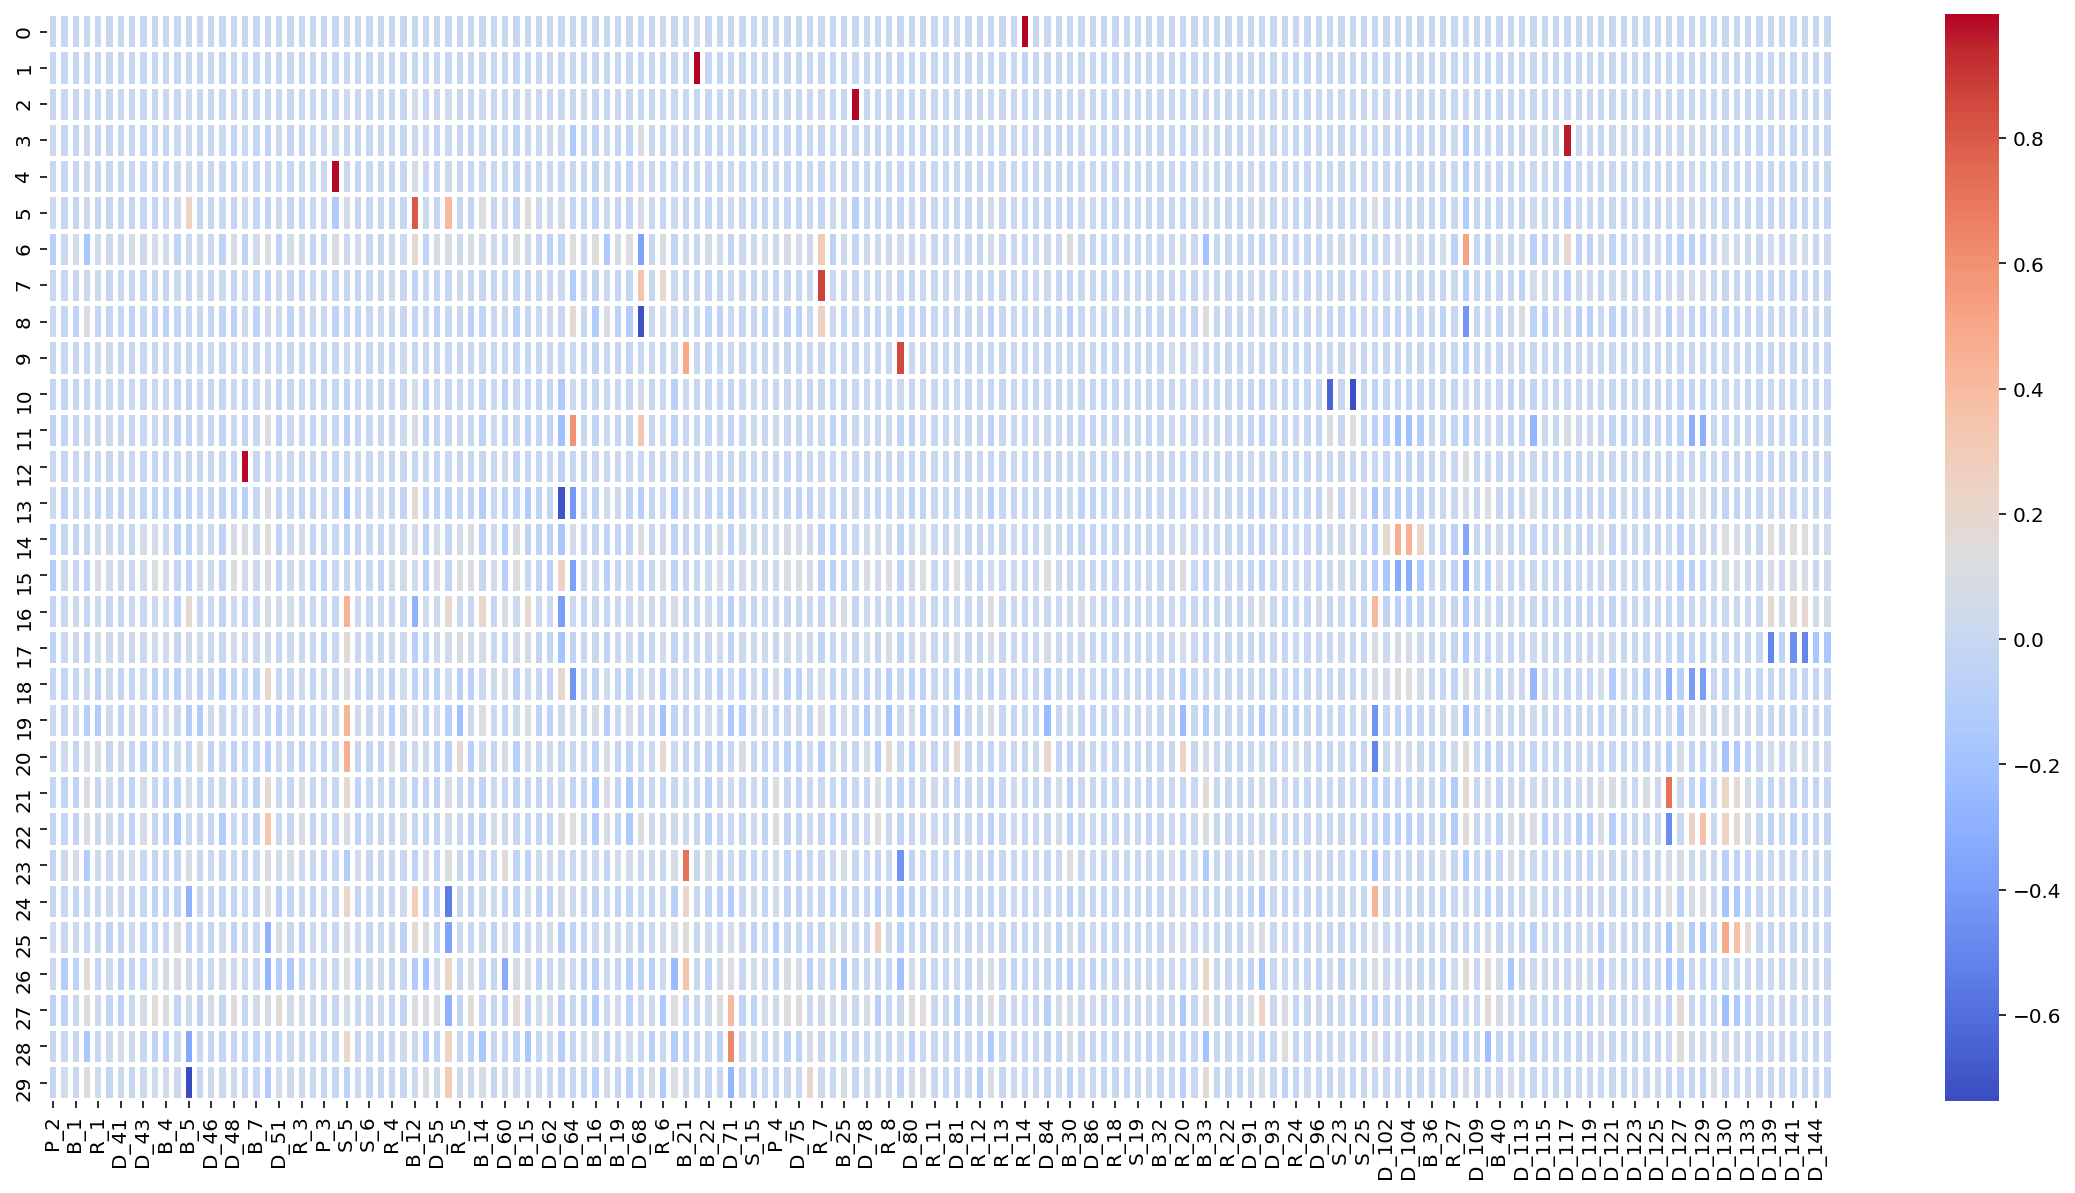

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(df_comp, annot=False, cmap='coolwarm', linecolor='white', linewidths=2)

In [24]:
pca.explained_variance_

array([55.17363291, 33.30206562, 10.86834123,  5.73842943,  3.87446421,
        3.28203441,  2.67261874,  2.28867219,  1.98913717,  1.04358856,
        0.90940326,  0.75211178,  0.73675324,  0.68801226,  0.59372805,
        0.49043032,  0.41190754,  0.38911074,  0.37352142,  0.33131912,
        0.29437656,  0.25945799,  0.25614846,  0.22221429,  0.21836937,
        0.21347195,  0.21012252,  0.19381524,  0.18333811,  0.17319694])

The pc1 has var = 55.17363291. (The higher the number, the more important it is.)

In [25]:
pca.explained_variance_ratio_.cumsum()

array([0.41642237, 0.66776933, 0.74979801, 0.79310874, 0.82235122,
       0.84712233, 0.86729389, 0.88456762, 0.89958061, 0.90745708,
       0.9143208 , 0.91999735, 0.92555799, 0.93075075, 0.93523191,
       0.93893342, 0.94204229, 0.9449791 , 0.94779825, 0.95029888,
       0.95252068, 0.95447894, 0.95641221, 0.95808937, 0.95973751,
       0.96134869, 0.96293459, 0.96439741, 0.96578115, 0.96708835])

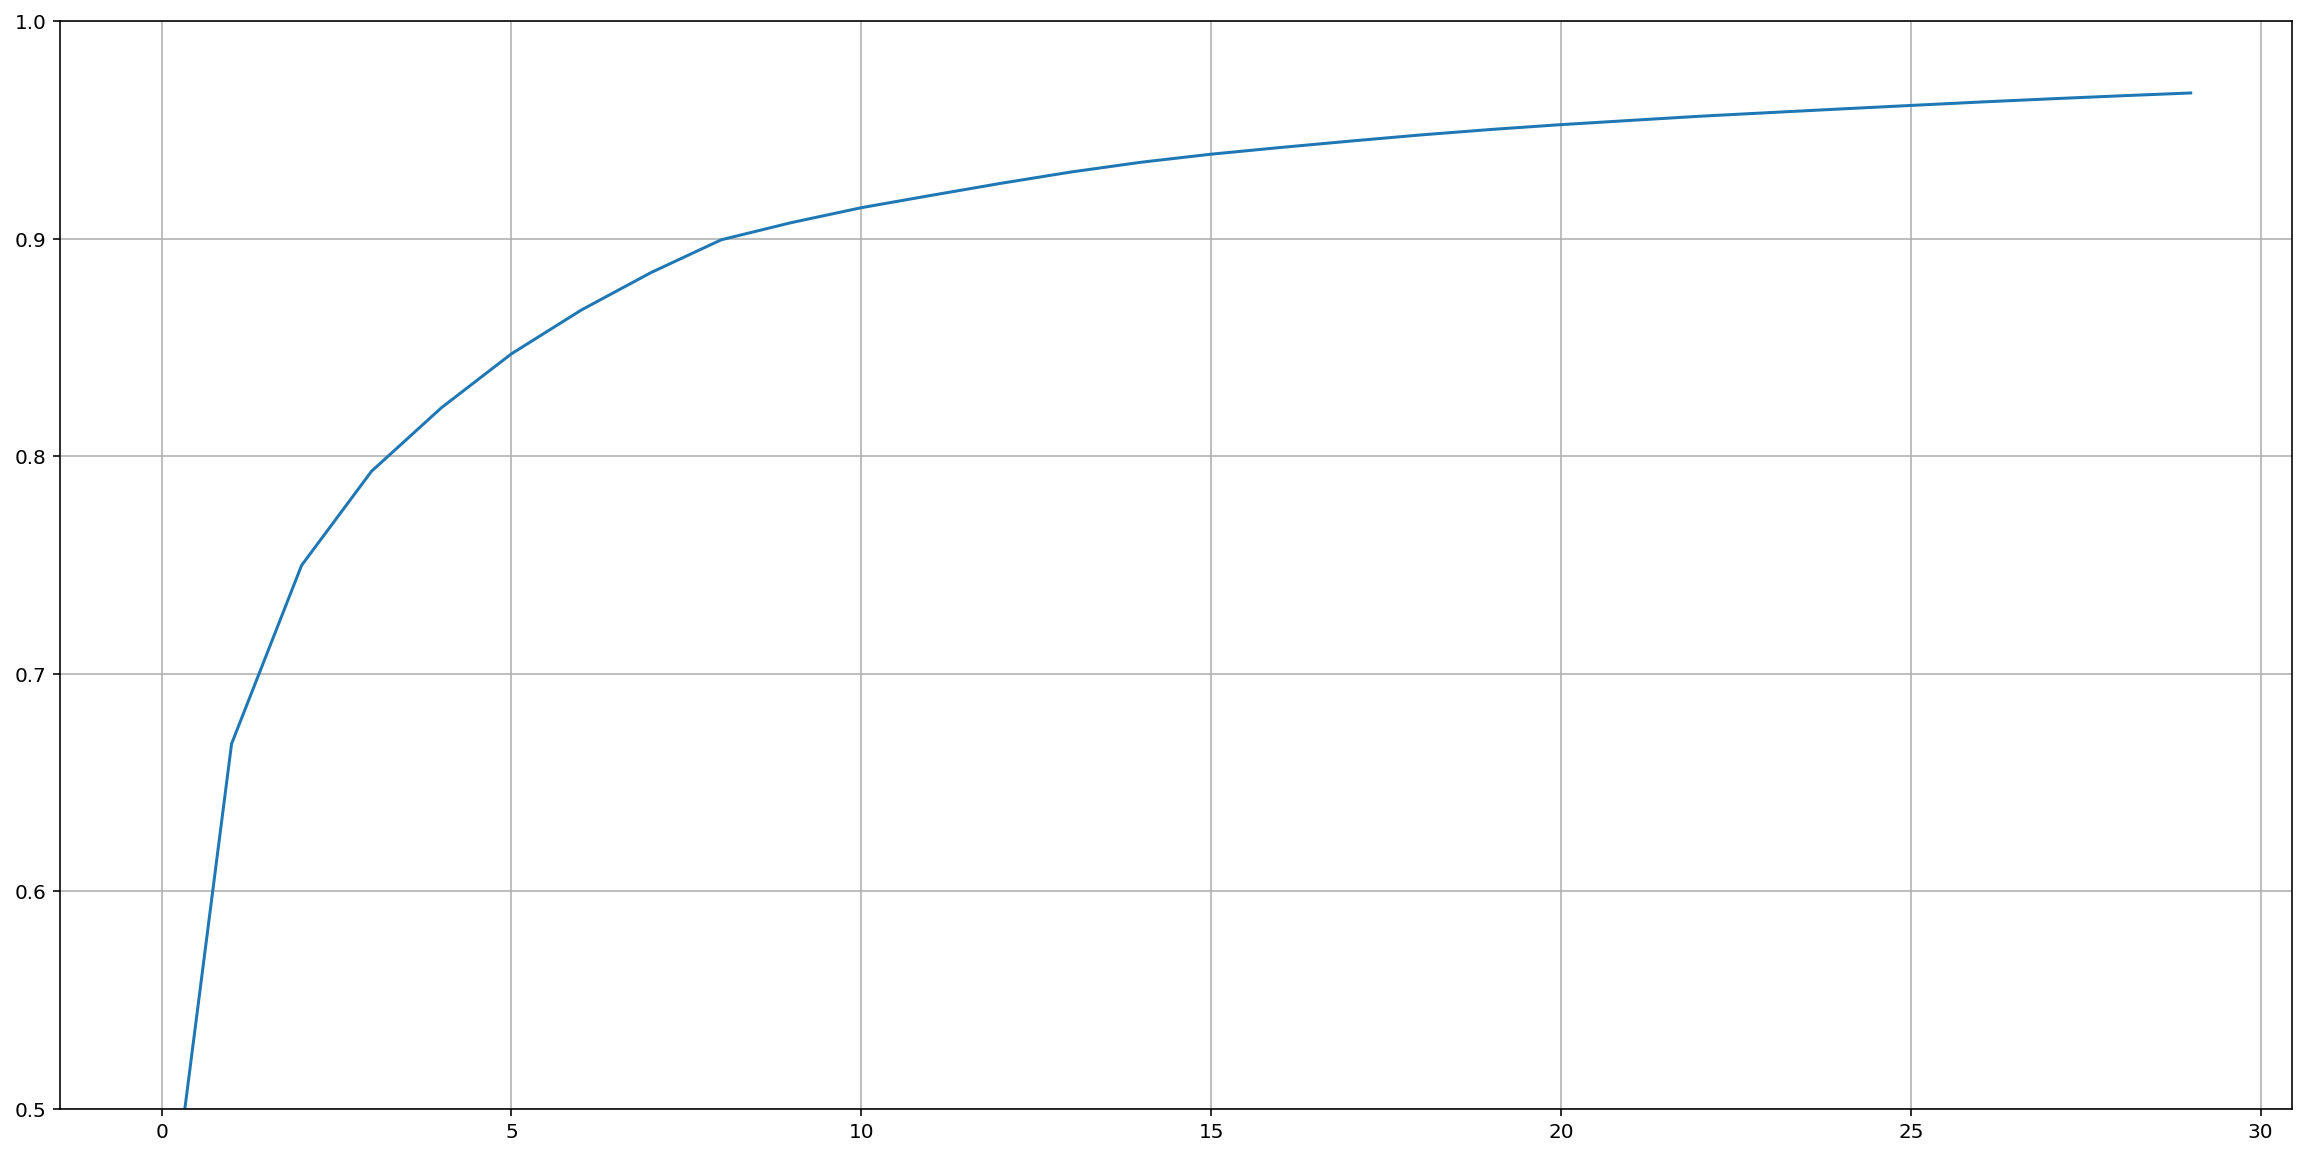

In [26]:
plt.figure(figsize=(20,10))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylim(0.5,1)
plt.grid()

In [27]:
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  30 ;
Total explained variance =  0.96709


The variance among those components is up to 96.7%.  
Therefore, 30 components can capture enough information.

## 1.1 Logistic Regression with PCA

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [ ]:
from sklearn.linear_model import LogisticRegression

logit_pca = LogisticRegression(max_iter=1000)
logit_pca.fit(X_train_pca, y_train)

Running time is approximately 20 seconds.

In [29]:
# Save Model
#joblib.dump(logit_pca, './models/Logit_PCA.pkl')

# Load Model
logit_pca = joblib.load('./models/Logit_PCA.pkl')

In [30]:
logistic_predicted_pca = logit_pca.predict(X_test_pca)

In [31]:
confusion_matrix(y_test, logistic_predicted_pca)

array([[188437,  12897],
       [ 18231,  40759]])

[ TN FP ]  
[ FN TP ]

TP (Predict as default; the truth is default)  
TN (Predict as not default; the truth is not default)  
FP (Predict as default; the truth is not default)  
FN (Predict as not default; the truth is default)

In [32]:
my_eval('Logit_PCA',y_test,logistic_predicted_pca)

Logit_PCA Results
Accuracy:  0.8804259307632027
F1 Score:  0.7236652877154981
Precision:  0.7596354554942597
Recall:  0.6909476182403798


Logit        NB        DT        RF  Logit_PCA
Accuracy   0.890152  0.860389  0.862033  0.908353   0.880426
F1 Score   0.750402  0.706927  0.695627  0.795428   0.723665
Precision  0.773436  0.674146  0.695509  0.804785   0.759635
Recall     0.728700  0.743058  0.695745  0.786286   0.690948

## 1.2 Naive Bayes with PCA

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)

Running time is approximately 1 second.

In [33]:
# Save Model
#joblib.dump(nb_pca, './models/NB_PCA.pkl')

# Load Model
nb_pca = joblib.load('./models/NB_PCA.pkl')

In [34]:
nb_predicted_pca = nb_pca.predict(X_test_pca)

In [35]:
confusion_matrix(y_test, nb_predicted_pca)

array([[191633,   9701],
       [ 32507,  26483]])

In [36]:
my_eval('NB_PCA',y_test,nb_predicted_pca)

NB_PCA Results
Accuracy:  0.837863585378221
F1 Score:  0.5565175363019312
Precision:  0.7318980764978996
Recall:  0.4489404983895576


Logit        NB        DT        RF  Logit_PCA    NB_PCA
Accuracy   0.890152  0.860389  0.862033  0.908353   0.880426  0.837864
F1 Score   0.750402  0.706927  0.695627  0.795428   0.723665  0.556518
Precision  0.773436  0.674146  0.695509  0.804785   0.759635  0.731898
Recall     0.728700  0.743058  0.695745  0.786286   0.690948  0.448940

## 1.3 Decision Tree with PCA

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree_pca = DecisionTreeClassifier()
dtree_pca.fit(X_train_pca, y_train)

Running time is approximately 2 minutes.

In [37]:
# Save Model
#joblib.dump(dtree_pca, './models/DT_PCA.pkl')

# Load Model
dtree_pca = joblib.load('./models/DT_PCA.pkl')

In [38]:
dtree_predicted_pca = dtree_pca.predict(X_test_pca)

In [39]:
confusion_matrix(y_test, dtree_predicted_pca)

array([[182822,  18512],
       [ 18105,  40885]])

In [40]:
my_eval('DT_PCA',y_test,dtree_predicted_pca)

DT_PCA Results
Accuracy:  0.8593406677832239
F1 Score:  0.6907008370851528
Precision:  0.6883344276646969
Recall:  0.6930835734870316


Logit        NB        DT        RF  Logit_PCA    NB_PCA  \
Accuracy   0.890152  0.860389  0.862033  0.908353   0.880426  0.837864   
F1 Score   0.750402  0.706927  0.695627  0.795428   0.723665  0.556518   
Precision  0.773436  0.674146  0.695509  0.804785   0.759635  0.731898   
Recall     0.728700  0.743058  0.695745  0.786286   0.690948  0.448940   

             DT_PCA  
Accuracy   0.859341  
F1 Score   0.690701  
Precision  0.688334  
Recall     0.693084

## 1.4 Random Forest with PCA

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)

Running time is approximately 25 minutes.

In [41]:
# Save Model
#joblib.dump(rf_pca, './models/RF_PCA.pkl')

# Load Model
rf_pca = joblib.load('./models/RF_PCA.pkl')

In [42]:
rf_predicted_pca = rf_pca.predict(X_test_pca)

In [43]:
confusion_matrix(y_test, rf_predicted_pca)

array([[191239,  10095],
       [ 12868,  46122]])

In [44]:
my_eval('RF_PCA',y_test,rf_predicted_pca)

RF_PCA Results
Accuracy:  0.9117906915996988
F1 Score:  0.800680514204866
Precision:  0.820427984417525
Recall:  0.7818613324292253


Logit        NB        DT        RF  Logit_PCA    NB_PCA  \
Accuracy   0.890152  0.860389  0.862033  0.908353   0.880426  0.837864   
F1 Score   0.750402  0.706927  0.695627  0.795428   0.723665  0.556518   
Precision  0.773436  0.674146  0.695509  0.804785   0.759635  0.731898   
Recall     0.728700  0.743058  0.695745  0.786286   0.690948  0.448940   

             DT_PCA    RF_PCA  
Accuracy   0.859341  0.911791  
F1 Score   0.690701  0.800681  
Precision  0.688334  0.820428  
Recall     0.693084  0.781861

---
# 2. Performance Graph Comparison
---

In [45]:
df_model_compare.to_csv('./eval_results/eval_results_with_PCA.csv')

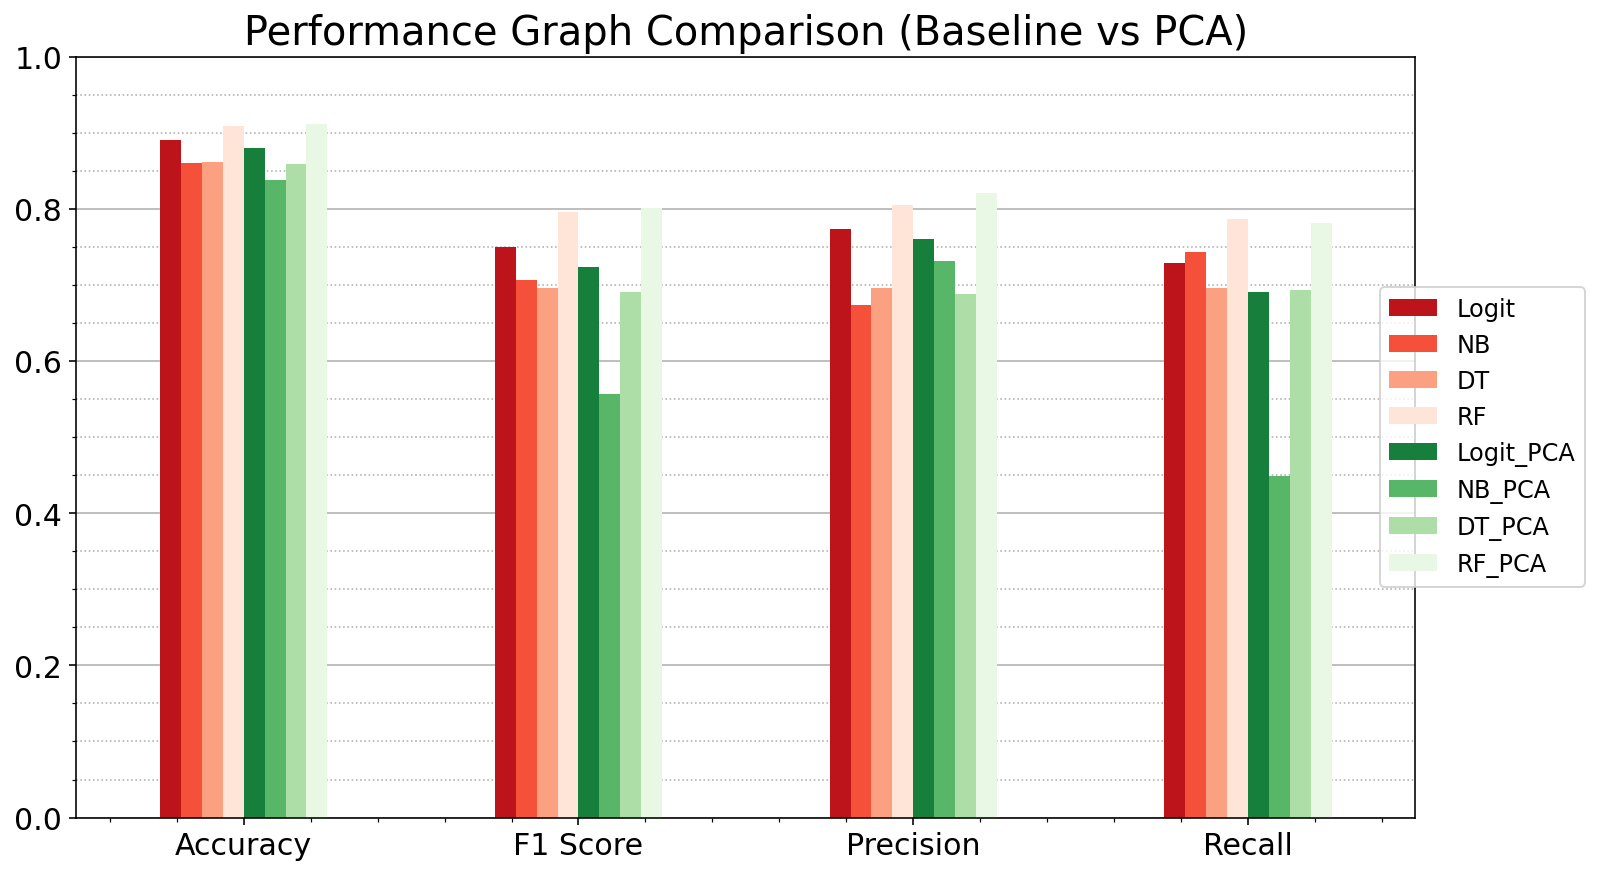

In [46]:
cmap1 = plt.cm.Reds
cmap2 = plt.cm.Greens
colors = [*cmap1(np.linspace(.8, .1, 4)),
          *cmap2(np.linspace(.8, .1, 4)),]

ax = df_model_compare.plot(
    kind='bar', color=colors, rot=0,
    ylim=(0,1), figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12, loc='center', bbox_to_anchor=(1.05,0.5))

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.title('Performance Graph Comparison (Baseline vs PCA)', fontsize=20)
plt.savefig('./img/graph_PCA')
plt.show()

After the PCA was performed, the performance did not decrease significantly, except for the Naive Bayes that F1 and Recall scores decreased significantly.

In [47]:
columns = ['Logit','NB','DT','RF']
rows = ['Baseline','PCA (n=30)']
values = [[5,0.08,20,60],[0.33,0.02,2,25]]

df_running_time = pd.DataFrame(values,rows,columns)

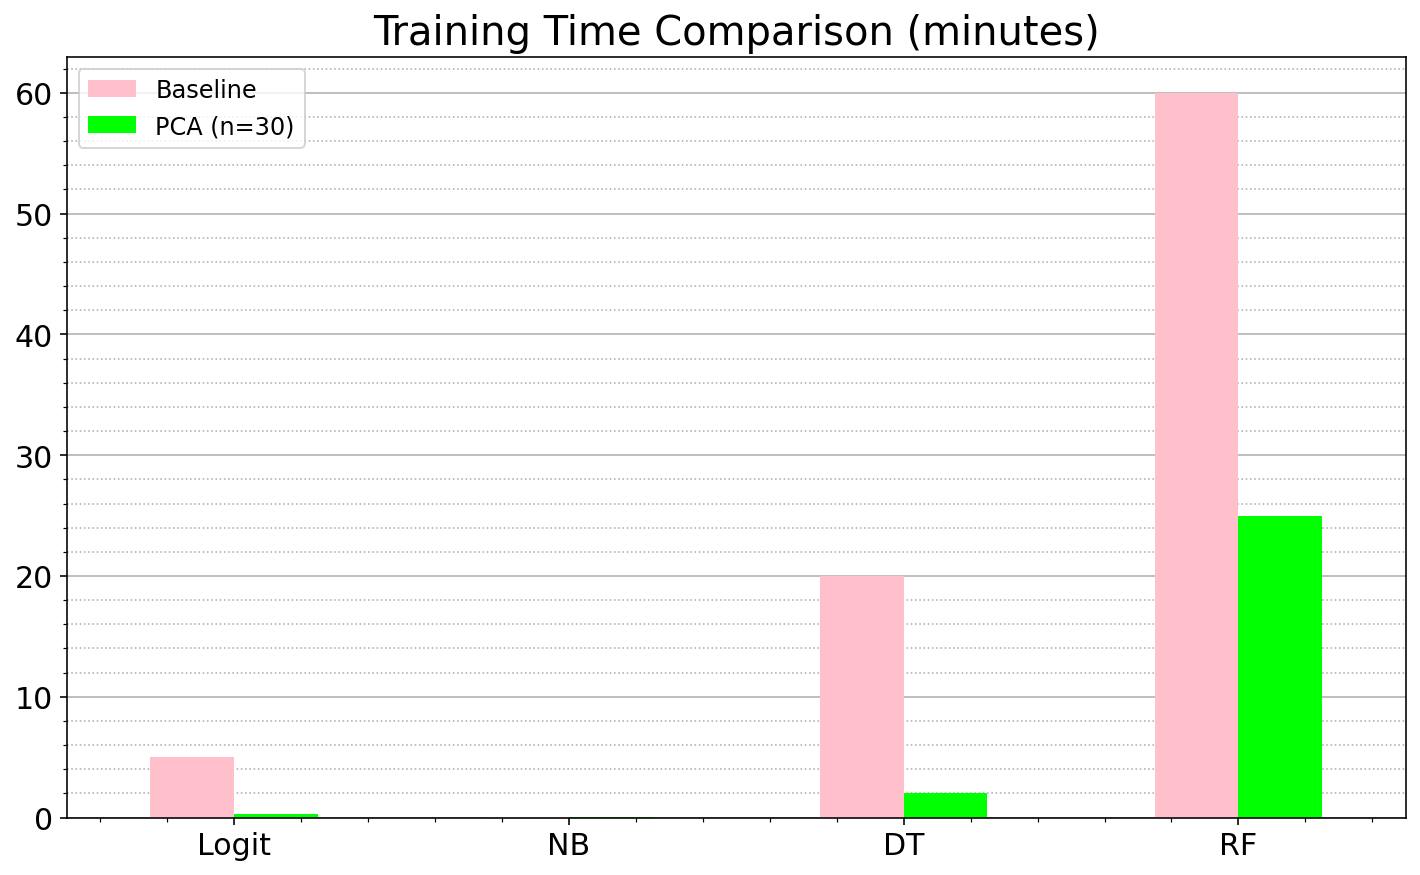

In [48]:
ax = df_running_time.T.plot(
    kind='bar', color=['pink','lime'], rot=0,
    figsize = (12,7), fontsize=15
)
ax.set_axisbelow(True)
ax.grid(linestyle='-', axis='y')
ax.legend(fontsize=12)

plt.minorticks_on()
plt.grid(which='minor', axis='y',ls=':')
plt.title('Training Time Comparison (minutes)', fontsize=20)
plt.savefig('./img/running_time_PCA')
plt.show()

Running on Intel Core i5-8250U 1.8GHz 4 cores 8 threads

---
# Kindly continue on the next notebook: (3 of 3) LDA